<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
from sklearn import svm
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt


Ahora, cargamos los datos de prueba en los arreglos `X_train` y `y_train`:

In [10]:
df    = pd.read_csv('demanda.csv')

## Procesamos datos de entrenamiento 
dftrain = df.loc[df.iloc[:,20].isin(['T'])] ## 'T' = training set
y_train = dftrain['Y'].to_numpy()  
X_train = dftrain[['X0','X1','X2','X3','X4','X5','X6','X7','X8','X9','X10']].to_numpy() ## Regresores

## Procesamos datos de prueba 
dftest = df.loc[df.iloc[:,20].isin(['F'])] ## 'F' = test set
y_test = dftest['Y'].to_numpy()
X_test = dftest[['X0','X1','X2','X3','X4','X5','X6','X7','X8','X9','X10']].to_numpy() ## Regresores

In [11]:
def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)

In [12]:
model = LinearRegression()
model.fit(X_train, y_train)
r_sq = model.score(X_test, y_test)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)
y_pred = model.predict(X_test)
mae_rlm  = trunc(mean_absolute_error(y_test,y_pred),4)
mse_rlm  = trunc(mean_squared_error(y_test,y_pred),4)
mape_rlm = trunc(mean_absolute_percentage_error(y_test,y_pred),4)

coefficient of determination: 0.7459708965464427
intercept: -665.3444836197305
slope: [ 0.          0.28749465  0.29204618  0.25861088 -0.04431544 -0.14208937
 -0.02613895  0.18289727  0.33580077  0.06905434 -0.12973508]


In [13]:
mae_svm = []; mse_svm = []; mape_svm = []; Clist = []; perc_within_eps_list = []
epsilon = 10
for c in range(34, 65, 2):
    Clist.append(c)
    model = svm.SVR(kernel='rbf', C=c, epsilon=epsilon)
    model.fit(X_train, y_train)
    #r_sq = model.score(X_test, y_test)
    #print('coefficient of determination:', r_sq)
    
    y_pred = model.predict(X_test)
    mae_svm.append(trunc(mean_absolute_error(y_test,y_pred),4))
    mse_svm.append(trunc(mean_squared_error(y_test,y_pred),4))
    mape_svm.append(trunc(mean_absolute_percentage_error(y_test,y_pred),4))
    
    perc_within_eps = 100*np.sum(abs(y_test-y_pred) <= epsilon) / len(y_test)
    perc_within_eps_list.append(perc_within_eps)

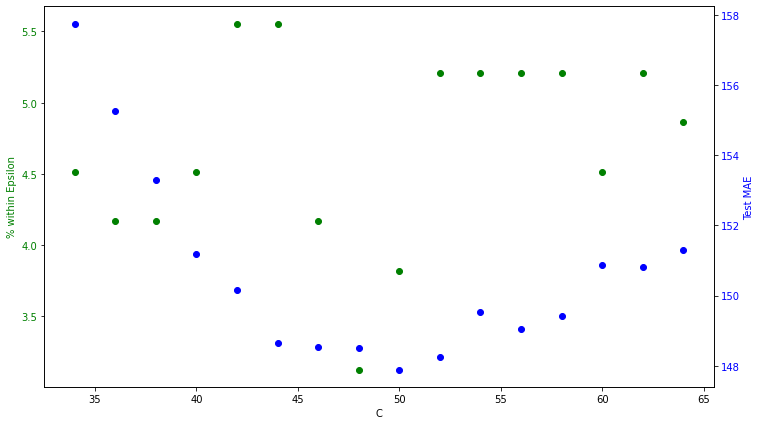

In [14]:
fig, ax1 = plt.subplots(figsize=(12,7))

color='green'
ax1.set_xlabel('C')
ax1.set_ylabel('% within Epsilon', color=color)
ax1.scatter(Clist, perc_within_eps_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color='blue'
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Test MAE', color=color)  # we already handled the x-label with ax1
ax2.scatter(Clist, mae_svm, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

In [15]:
print('| REGRESIÓN      | C              | MAE            | MSD            | MAPE         | % WITHIN EPSILON = ',epsilon,'       |')
print('| :------------- | :------------- | -------------: | -------------: |-------------:|-------------:|')
print('|    lineal      |         ',       0,'    |    ',str(mae_rlm),'  |    ',str(mse_rlm),'    |    ',str(mape_rlm),'|' )
for i in range(len(Clist)):
    print('|     SVM        |       ',  Clist[i]  ,'    |    ',str(mae_svm[i]),'   |    ',
       str(mse_svm[i]),'    |    ',str(mape_svm[i]),'    |    ',str(perc_within_eps_list[i]),'|',)


| REGRESIÓN      | C              | MAE            | MSD            | MAPE         | % WITHIN EPSILON =  10        |
| :------------- | :------------- | -------------: | -------------: |-------------:|-------------:|
|    lineal      |          0     |     167.1343   |     48064.1398     |     0.0192 |
|     SVM        |        34     |     157.7527    |     40492.4957     |     0.0178     |     4.513888888888889 |
|     SVM        |        36     |     155.2705    |     39724.3767     |     0.0175     |     4.166666666666667 |
|     SVM        |        38     |     153.3079    |     39071.4905     |     0.0173     |     4.166666666666667 |
|     SVM        |        40     |     151.1791    |     38347.9321     |     0.017     |     4.513888888888889 |
|     SVM        |        42     |     150.1678    |     38003.4596     |     0.0169     |     5.555555555555555 |
|     SVM        |        44     |     148.6552    |     37430.3631     |     0.0168     |     5.555555555555555 |
|     S

In [25]:
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
#https://github.com/tomsharp/SVR/blob/master/SVR.ipynb
parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':Clist,'epsilon': [0,2,5,10,12,15]} #'epsilon': np.linspace(1, 20),'kernel':('linear', 'poly', 'rbf', 'sigmoid')
model = svm.SVR()
clf   = GridSearchCV(model, parameters,scoring='neg_mean_absolute_error', cv=5)
clf.fit(X_train, y_train)
model = clf.best_estimator_
model.fit(X_train, y_train)

print(sorted(clf.cv_results_.keys()))
print(clf.best_estimator_)

r_sq = model.score(X_test, y_test)
print('coefficient of determination:', r_sq)
    
y_pred = model.predict(X_test)

['mean_fit_time', 'mean_score_time', 'mean_test_score', 'param_C', 'param_epsilon', 'param_kernel', 'params', 'rank_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'std_fit_time', 'std_score_time', 'std_test_score']
SVR(C=34, epsilon=2, kernel='poly')
coefficient of determination: 0.7601691787764767


In [26]:
print("C: {}".format(model.C))
print("Epsilon: {}".format(model.epsilon))
print("Kernel: {}".format(model.kernel))
    
#print("Intercept: {:,.3f}".format(model.intercept_[0]))
#print("Coefficient: {:,.3f}".format(model.coef_[0]))
    
mae = mean_absolute_error(y_test, model.predict(X_test))
print("MAE = {:,.2f}".format(1000*mae))
    
perc_within_eps = 100*np.sum(y_test - model.predict(X_test) < epsilon) / len(y_test)
print("Percentage within Epsilon = {:,.2f}%".format(perc_within_eps))

C: 34
Epsilon: 2
Kernel: poly
MAE = 165,260.73
Percentage within Epsilon = 36.46%


Ephsilon permite que los elementos queden del lado equivocado del hiperplano
C es el costo en la función objetivo por la distancia 

Support Vector Machine también se puede utilizar como método de regresión, manteniendo todas las características principales que caracterizan al algoritmo (margen máximo). Support Vector Regression (SVR) utiliza los mismos principios que SVM para la clasificación, con solo algunas diferencias menores. Primero, debido a que la salida es un número real, se vuelve complicado predecir la información disponible con infinitas posibilidades. En el caso de regresión, se establece un margen de tolerancia (épsilon) de aproximación al SVM que ya habría pedido el problema. Pero además de este hecho, también hay una razón más complicada; el algoritmo es más complicado. Por lo tanto, debe tenerse en cuenta. Sin embargo, la idea principal siempre es la misma: minimizar el error e identificar el hiperplano que maximiza el margen, teniendo en cuenta que se tolera parte del error.

[Support Vector Machine - Regression (SVR) ****](http://www.saedsayad.com/support_vector_machine_reg.htm)


[https://towardsdatascience.com/an-introduction-to-support-vector-regression-svr-a3ebc1672c2](https://towardsdatascience.com/an-introduction-to-support-vector-regression-svr-a3ebc1672c2)

[Grid Search over C and Epsilon](https://github.com/tomsharp/SVR/blob/master/SVR.ipynb)

https://scikit-learn.org/stable/modules/svm.html

https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html

https://medium.com/pursuitnotes/support-vector-regression-in-6-steps-with-python-c4569acd062d

https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/?utm_source=blog&utm_medium=support-vector-regression-tutorial-for-machine-learning